In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image


In [2]:
dataset_dir = "/Users/suparnac/dev_envs/CV_Projects/Animal_Image_Classification/dataset"

In [3]:
categories = [cat for cat in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cat))]
category_counts = {cat: len(os.listdir(os.path.join(dataset_dir, cat))) for cat in categories}
print("Categories and image counts:", category_counts)

Categories and image counts: {'Cat': 123, 'Dog': 122, 'Dolphin': 129, 'Giraffe': 129, 'Bear': 125, 'Zebra': 137, 'Panda': 135, 'Tiger': 129, 'Bird': 137, 'Kangaroo': 126, 'Horse': 130, 'Cow': 131, 'Deer': 127, 'Lion': 131, 'Elephant': 133}


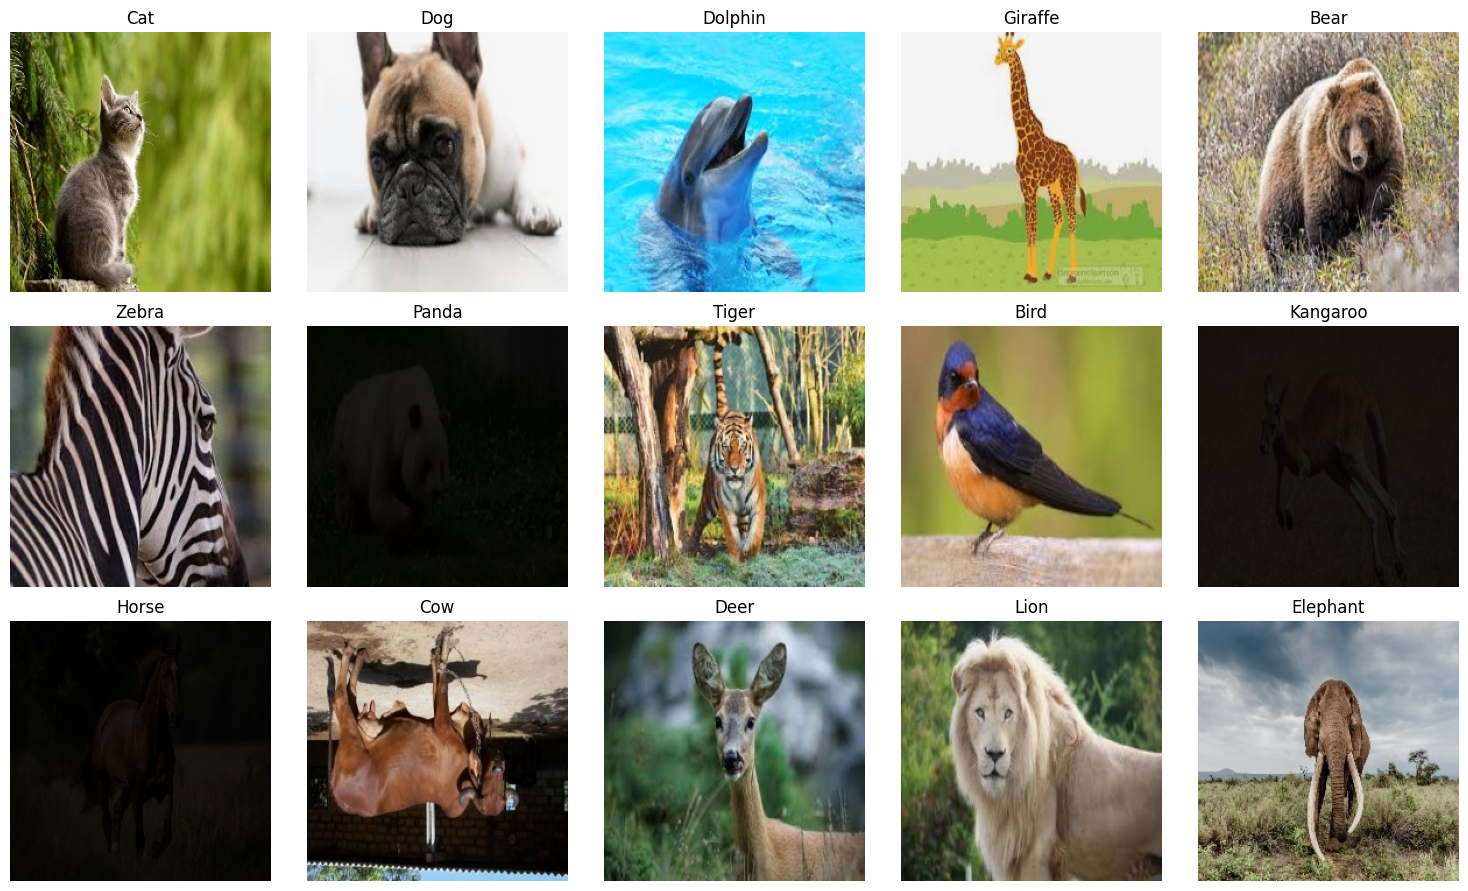

In [4]:
# Visualize samples
fig, axes = plt.subplots(3, 5, figsize=(15, 9))
for idx, cat in enumerate(categories):
    img_list = os.listdir(os.path.join(dataset_dir, cat))
    img_path = os.path.join(dataset_dir, cat, img_list[0])
    img = Image.open(img_path)
    ax = axes[idx // 5][idx % 5]
    ax.imshow(img)
    ax.set_title(cat)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


In [6]:
#image transformations
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),         # Resize images to 128x128 
    transforms.RandomHorizontalFlip(),     # Data augmentation
    transforms.ToTensor(),                  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means 
                         std=[0.229, 0.224, 0.225])   # ImageNet std devs 
])

transform_val = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [7]:
###Geting all image paths and labels first
all_image_paths = []
all_labels = []

categories = [cat for cat in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, cat))]
category_to_idx = {cat: idx for idx, cat in enumerate(categories)}

for cat in categories:
    folder_path = os.path.join(dataset_dir, cat)
    for img_file in os.listdir(folder_path):
        all_image_paths.append(os.path.join(folder_path, img_file))
        all_labels.append(category_to_idx[cat])



In [8]:
###Spliting 80-20 80% train, 20% val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)


In [9]:
# Create custom dataset class
from PIL import Image
from torch.utils.data import Dataset

class AnimalDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label



In [10]:
# Create datasets
train_dataset = AnimalDataset(train_paths, train_labels, transform=transform_train)
val_dataset = AnimalDataset(val_paths, val_labels, transform=transform_val)



In [11]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 1555
Number of validation samples: 389


In [12]:
import torch.nn as nn
import torch.nn.functional as F


In [13]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # considering input resized to 128x128
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128x128 -> 64x64
        x = self.pool(F.relu(self.conv2(x)))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv3(x)))  # 32x32 -> 16x16
        x = x.view(-1, 128 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [14]:
# Create model instance
model = SimpleCNN(num_classes=len(categories))
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


In [15]:
import torch.optim as optim
import torch


In [16]:
# Set device (to MPS)
device = torch.device("mps")
print(f"Using device: {device}")


In [17]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
# Training function
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc



In [19]:
# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [20]:
num_epochs = 25
patience = 3  # Early stopping patience
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'models/best_model.pth')  # Save best model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


Epoch 1/25: Train Loss: 2.6603, Train Acc: 0.1068, Val Loss: 2.5379, Val Acc: 0.1877
Epoch 2/25: Train Loss: 2.4821, Train Acc: 0.1884, Val Loss: 2.3851, Val Acc: 0.2288
Epoch 3/25: Train Loss: 2.2663, Train Acc: 0.2482, Val Loss: 2.2024, Val Acc: 0.2982
Epoch 4/25: Train Loss: 2.0016, Train Acc: 0.3267, Val Loss: 1.9403, Val Acc: 0.3419
Epoch 5/25: Train Loss: 1.7631, Train Acc: 0.4354, Val Loss: 1.7275, Val Acc: 0.4704
Epoch 6/25: Train Loss: 1.4527, Train Acc: 0.5280, Val Loss: 1.6680, Val Acc: 0.4679
Epoch 7/25: Train Loss: 1.2317, Train Acc: 0.6180, Val Loss: 1.4322, Val Acc: 0.5861
Epoch 8/25: Train Loss: 0.9984, Train Acc: 0.6926, Val Loss: 1.4091, Val Acc: 0.5861
Epoch 9/25: Train Loss: 0.8466, Train Acc: 0.7370, Val Loss: 1.3487, Val Acc: 0.6530
Epoch 10/25: Train Loss: 0.7741, Train Acc: 0.7614, Val Loss: 1.2498, Val Acc: 0.6838
Epoch 11/25: Train Loss: 0.6076, Train Acc: 0.8084, Val Loss: 1.3290, Val Acc: 0.6735
Epoch 12/25: Train Loss: 0.5806, Train Acc: 0.8193, Val Loss: 1

In [21]:
import torchvision.models as models

In [22]:
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer for 15 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(categories))

# Move model to device
model = model.to(device)

# Use a lower learning rate for transfer learning
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)



/Users/suparnac/dev_envs/cv_env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/suparnac/dev_envs/cv_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Also update your image size to 224x224 (standard for pretrained models)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),         # ResNet expects 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),         # Add rotation for more augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Add color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [24]:
#freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


In [25]:
#optimizer to include only trainable parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=1e-4, weight_decay=1e-4)


In [26]:
# Training loop (with early stopping)
num_epochs = 100
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'models/best_resnet18.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break



Epoch 1/100: Train Loss: 2.7848, Train Acc: 0.1087, Val Loss: 2.5878, Val Acc: 0.1388
Epoch 2/100: Train Loss: 2.4420, Train Acc: 0.2193, Val Loss: 2.2786, Val Acc: 0.2725
Epoch 3/100: Train Loss: 2.1709, Train Acc: 0.3621, Val Loss: 2.0163, Val Acc: 0.4344
Epoch 4/100: Train Loss: 1.9335, Train Acc: 0.4971, Val Loss: 1.7926, Val Acc: 0.5476
Epoch 5/100: Train Loss: 1.7457, Train Acc: 0.5801, Val Loss: 1.6295, Val Acc: 0.6093
Epoch 6/100: Train Loss: 1.6033, Train Acc: 0.6495, Val Loss: 1.4782, Val Acc: 0.6710
Epoch 7/100: Train Loss: 1.4770, Train Acc: 0.6875, Val Loss: 1.3625, Val Acc: 0.7121
Epoch 8/100: Train Loss: 1.3705, Train Acc: 0.7164, Val Loss: 1.2797, Val Acc: 0.7326
Epoch 9/100: Train Loss: 1.2914, Train Acc: 0.7331, Val Loss: 1.1972, Val Acc: 0.7455
Epoch 10/100: Train Loss: 1.2269, Train Acc: 0.7460, Val Loss: 1.1491, Val Acc: 0.7635
Epoch 11/100: Train Loss: 1.1642, Train Acc: 0.7640, Val Loss: 1.1230, Val Acc: 0.7635
Epoch 12/100: Train Loss: 1.0907, Train Acc: 0.7833,